<a id="title_ID"></a>
# Using Kepler Data to Plot a Light Curve 
<br>This notebook tutorial demonstrates the process of loading and extracting information from Kepler light curve FITS files to plot a light curve and display the photometric aperture. 
<div style="text-align: left">  



***

<a id="intro_ID"></a>
## Introduction

**Light curve background:**
A light curve is a plot of flux versus time that shows the variability of light output from an object. This is one way to find planets periodically transitting a star. The light curves made here will plot the corrected and uncorrected fluxes from Kepler data of object KIC 11446443 (TRES-2). 

**Some notes about the file:** kplr_011446443-2009131110544_slc.fits
<br>The filename contains phrases for identification, where
 - kplr = Kepler 
 - 011446443 = Kepler ID number
 - 2009131110544 = year 2009, day 131, time 11:05:44
 - slc = short cadence

**Defining some terms:**
 - **Cadence:** the frequency with which summed data are read out. Files are either short cadence (a 1 minute sum) or long cadence (a 30 minute sum).
 - **SAP Flux:** Simple Aperture Photometry flux; flux after summing the calibrated pixels within the optimal aperture
 - **PDCSAP Flux:** Pre-search Data Conditioned Simple Aperture Photometry; these are the flux values nominally corrected for instrumental variations. 
 - **BJD:** Barycentric Julian Day; this is the Julian Date that has been corrected for differences in the Earth's position with respect to the Solar System Barycentre (center of mass of the Solar System).
 - **HDU:** Header Data Unit; a FITS file is made up of Header or Data units that contain information, data, and metadata relating to the file. The first HDU is called the primary, and anything that follows is considered an extension. 


***

<a id="imports_ID"></a>
## Imports
Let's start by importing some libraries to the environment: 
- *matplotlib notebook* for creating interactive plots 
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib* for plotting data

In [25]:
%matplotlib notebook
from astropy.io import fits
from astropy.table import Table 
import matplotlib.pyplot as plt

[Top of Page](#title_ID)

***

<a id="data_ID"></a>
## Getting the Data
Start by importing libraries from Astroquery. For a longer, more detailed description using of Astroquery, please visit this [tutorial](https://github.com/spacetelescope/MAST-API-Notebooks/blob/master/MUG2018_APITutorial_Astroquery.ipynb) or read the Astroquery [documentation](https://astroquery.readthedocs.io/en/latest/#). 

In [9]:
from astroquery.mast import Mast
from astroquery.mast import Observations

<br>Next, we need to find the data file. This is similar to searching for the data using the [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) in that we will be using certain keywords to find the file. The target name of the object we are looking for is kplr011446443, collected by the Kepler spacecraft.

In [10]:
keplerObs = Observations.query_criteria(target_name='kplr011446443', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[1])
yourProd = Observations.filter_products(keplerProds, extension='kplr011446443-2009131110544_slc.fits', 
                                        mrp_only=False)
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str60,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
601031,Kepler,timeseries,kplr011446443_sc_Q113313330333033302,Lightcurve Short Cadence (CSC) - Q0,C,mast:KEPLER/url/missions/kepler/lightcurves/0114/011446443/kplr011446443-2009131110544_slc.fits,SCIENCE,Minimum Recommended Products,SLC,--,Kepler,--,EX_STKS,kplr011446443-2009131110544_slc.fits,1457280,601031,PUBLIC,2


<br>Now that we've found the data file, we can download it using the reults shown in the table above:

In [11]:
Observations.download_products(yourProd, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str95,str8,object,object
./mastDownload\Kepler\kplr011446443_sc_Q113313330333033302\kplr011446443-2009131110544_slc.fits,COMPLETE,None,None


<br>Click on the blue URL above to download the file. You are now ready to complete the rest of the notebook.

[Top of Page](#title_ID)

***

<a id="header_ID"></a>
## Reading FITS Extensions
<br>Now that we have the file, we can start working with the data. We will begin by assigning a shorter name to the file to make it easier to use. Then, using the info function from astropy.io.fits, we can see some information about the FITS Header Data Units:

In [12]:
filename = "./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits"
fits.info(filename)

Filename: ./mastDownload/Kepler/kplr011446443_sc_Q113313330333033302/kplr011446443-2009131110544_slc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   14280R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (8, 9)   int32   


 - **No. 0 (Primary): **
 <br>This HDU contains meta-data related to the entire file.
 - **No. 1 (Light curve): **
 <br>This HDU contains a binary table that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.
 - **No. 2 (Aperture): **
 <br>This HDU contains the image extension with data collected from the aperture. We will also use this to display a bitmask plot that visually represents the optimal aperture used to create the SAP_FLUX column in HDU1.

For more detailed information about header extensions, look [here](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=17).

<br>Let's say we wanted to see more information about the extensions than what the fits.info command gave us. For example, we can access information stored in the header of the Binary Table extension (No. 1, LIGHTCURVE). The following line opens the FITS file, writes the first HDU extension into header1, and then closes the file. Only 24 columns are displayed here but you can view them all by adjusting the range: 

In [23]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header
  
print(repr(header1[0:24])) #repr() prints the info into neat columns

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                14280 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

<br> We can also view a table of the data from the Binary Table extension. This is where we can find the flux and time columns to be plotted later. Here only the first four rows of the table are displayed:

In [24]:
with fits.open(filename) as hdulist:
    binaryext = hdulist[1].data

binarytable = Table(binaryext)
binarytable[1:5]

TIME,TIMECORR,CADENCENO,SAP_FLUX,SAP_FLUX_ERR,SAP_BKG,SAP_BKG_ERR,PDCSAP_FLUX,PDCSAP_FLUX_ERR,SAP_QUALITY,PSF_CENTR1,PSF_CENTR1_ERR,PSF_CENTR2,PSF_CENTR2_ERR,MOM_CENTR1,MOM_CENTR1_ERR,MOM_CENTR2,MOM_CENTR2_ERR,POS_CORR1,POS_CORR2
float64,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
120.52992386784899,0.00096672785,5501,401288.16,91.51187,2598.1086,0.5752603,406100.9,127.528824,0,nan,nan,nan,nan,621.2181187542091,0.0002101067,848.8972881655714,0.00029125414,0.0002031729,-0.0025746305
120.53060508973431,0.00096674974,5502,401425.53,91.53448,2598.0261,0.57525027,406242.22,125.212105,0,nan,nan,nan,nan,621.2190207168474,0.00021018942,848.8935790650855,0.0002912894,0.00021144762,-0.0025837936
120.53128621167707,0.0009667717,5503,401172.0,91.517265,2597.9438,0.5752402,405984.03,123.31339,0,nan,nan,nan,nan,621.2179228162092,0.00021032244,848.894852260174,0.0002914222,0.00021972114,-0.0025929555
120.53196743356966,0.00096679357,5504,401473.62,91.53064,2597.8613,0.5752302,406293.0,121.84987,0,nan,nan,nan,nan,621.2198263101714,0.00021020704,848.8961790332079,0.00029115527,0.00022799587,-0.0026021185


[Top of Page](#title_ID)

***

<a id="lightcurve_ID"></a>
## Plotting a Light Curve
<br>Now that we have seen and accessed the data, we can begin to plot a light curve:

1. Open the file using command fits.open. This will allow the program to read and store the data we will manipulate to be plotted. Here we've also renamed the file with a phrase that is easier to handle (see line 1). 
<br>
<br>
2. Start by calibrating the time. Because the Kepler data is in BKJD (Kepler Barycentric Julian Day) we need to convert it to time in Julian Days (BJD) if we want to be able to compare it to other outside data. For a more detailed explanation about time conversions, visit the [page 13](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=13) or [page 17](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf#page=17) of the Kepler Archive Manual.
<br>
    - Read in the BJDREF times, both the integer (BJDREFI) and the floating point (BJDREFF). These are found as columns of data in the *binary extension* of the header. 
<br>
<br>
3. Read in the columns of times and fluxes (both uncorrected and corrected) from the data.

In [54]:
with fits.open(filename, mode="readonly") as hdulist:
    # Read in the "BJDREF" which is the time offset of the time array.
    bjdrefi = hdulist[1].header['BJDREFI'] 
    bjdreff = hdulist[1].header['BJDREFF']
    
    print(bjdrefi)
    print(bjdreff)

    # Read in the columns of data.
    times = hdulist[1].data['time'] 
    sap_fluxes = hdulist[1].data['SAP_FLUX']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

2454833
0.0


4. Now that the appropriate data has been read and stored, convert the times to BJDS by adding the BJDREF times to the data of times. 
<br>
<br>
5. Finally, we can plot the fluxes against time. We can also set a title and add a legend to the plot. We can label our fluxes accordingly and assign them colors and styles ("-k" for a black line, "-b" for a blue line).

In [55]:
%matplotlib inline

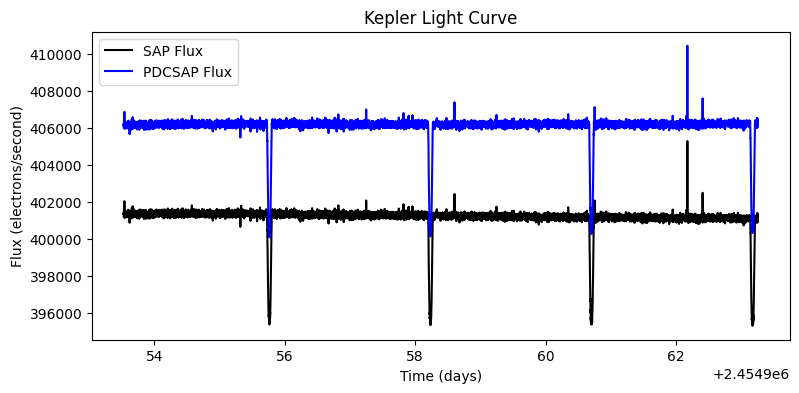

In [108]:
# Convert the time array to full BJD by adding the offset back in.
bjds = times + bjdrefi + bjdreff 

plt.figure(figsize=(9,4))

# Plot the time, uncorrected and corrected fluxes.
plt.plot(bjds, sap_fluxes, '-k', label='SAP Flux') 
plt.plot(bjds, pdcsap_fluxes, '-b', label='PDCSAP Flux') 

plt.title('Kepler Light Curve')
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Flux (electrons/second)')
plt.show()

[Top of Page](#title_ID)

***

In [59]:
sap_fluxes[0:100]

array([401333.16, 401288.16, 401425.53, 401172.  , 401473.62, 401465.44,
       401342.  , 401485.1 , 401244.03, 401389.53, 401256.7 , 401313.1 ,
       401323.5 , 401494.97, 401218.56, 402024.6 , 401337.28, 401196.97,
       401509.88, 401122.44, 401442.56, 401486.4 , 401250.78, 401266.28,
       401229.94, 401308.22, 401202.  , 401385.25, 401369.66, 401317.6 ,
       401281.72, 401351.53, 401316.47, 401311.97, 401250.2 , 401152.62,
       401294.72, 401423.5 , 401285.34, 401172.75, 401287.78, 401369.7 ,
       401352.4 , 401436.6 , 401262.2 , 401320.2 , 401380.47, 401172.62,
       401279.94, 401413.7 , 401351.88, 401377.94, 401198.97, 401332.  ,
       401203.94, 401185.1 , 401170.06, 401252.03, 401276.3 , 401391.88,
       401284.28, 401320.5 , 401328.94, 401299.4 , 401406.38, 401278.44,
       401472.1 , 401285.44, 401155.03, 401424.66, 401234.78, 401353.4 ,
       401233.38, 401254.22, 401251.2 , 401222.97, 401329.7 , 401451.78,
       401441.28, 401420.53, 401291.6 , 401454.34, 

In [71]:
# method to find time period!
import numpy as np
print(sap_fluxes.size)
a = 14280*0.37
print(a)
b = 14280*0.62
print(b)
a = 5284
b = 8854

14280
5283.6
8853.6


In [89]:
f1 = sap_fluxes[0:a]
f2 = sap_fluxes[a+1:b]
value = np.where(f1==min(f1))
value

(array([3281], dtype=int64),)

In [99]:
t1 = bjds[3281]
t1

2454955.7640689346

In [94]:
value2 = np.where(f2==min(f2))
value2

(array([1623], dtype=int64),)

In [100]:
t2 = bjds[1623+1+5284]
t2

2454958.234569723

In [102]:
t2 - t1 # this is the time period!!!

2.4705007881857455

## METHOD 2 

To find the period quantitatively, using a Lomb-Scargle Periodogram seems slightly inappropriate; this light curve doesn't resemble a sinusoid in any way. Instead we will use another Periodogram in astropy.timeseries called BoxLeastSquares. The usage is similar to LombScargle; so it is left to you to find the period of the transits, and hence the orbital period of the exoplanet.

We will be using BoxLeastSqaures

In [116]:
# There are some NaN values in the flux. So, we will find their indices to filter them out
sel_nan = np.isnan(sap_fluxes) #NaN = not a number
np.where(sel_nan==True)
# sap_fluxes[4064]

(array([ 4064,  4065,  4066,  4067,  4068,  4069,  4070,  4071,  4072,
         4073,  4074,  6679,  8414,  8415,  8416,  8417,  8418,  8419,
         8420,  8421,  8422,  8423,  8424, 11470, 11471, 11472, 11473,
        11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 12147,
        12148], dtype=int64),)

In [118]:
from astropy.timeseries import BoxLeastSquares

# Implement BoxLeastSquares
model = BoxLeastSquares(bjds[~sel_nan], sap_fluxes[~sel_nan]) # ~ is the unary Not operator
periodogram = model.autopower(0.2)

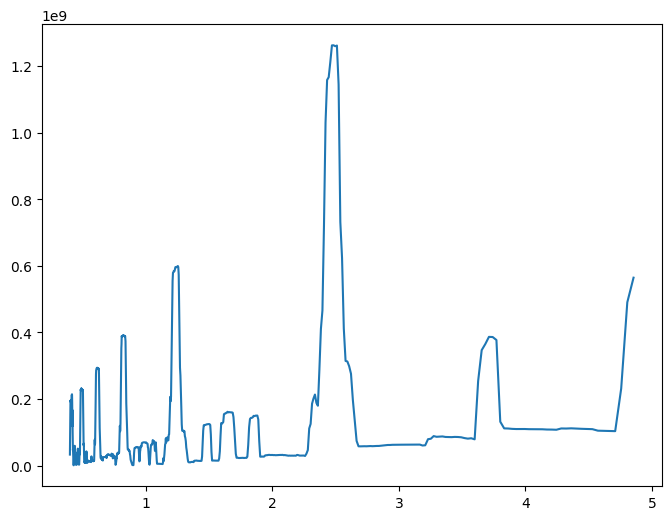

In [120]:
# Plot the power Spectrum
periods = periodogram.period
power = periodogram.power

plt.figure(figsize=(8,6))
plt.plot(periods, power)

2.4835596538949924


Text(0, 0.5, 'Flux [e/s]')

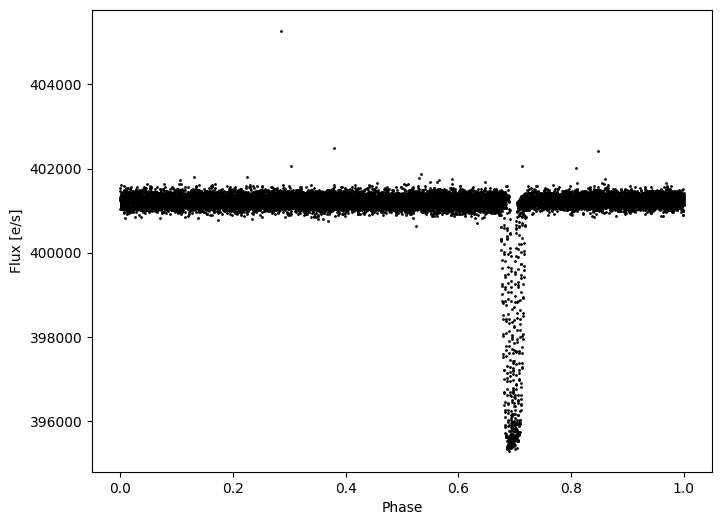

In [121]:
best_period = periods[np.argmax(power)]
# Plot the Phase-Folded Light curve for the Exoplant Transit using the Period found.

# The added phase to the time is just to center the transit.
phase = np.remainder(bjds, best_period)/best_period 

print(best_period)

plt.figure(figsize=(8,6))
plt.scatter(phase, sap_fluxes, s=1, color='k')
plt.xlabel("Phase")
plt.ylabel("Flux [e/s]")